In [ ]:
!pip install kmeans

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
#drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [3]:
data = pd.read_csv("drive/MyDrive/clustering/data.csv")
data

,customer_unique_id,recency_days,frequency,total_amount
0,0000366f3b9a7992bf8c76cfdf3221e2,1811.0,1.0,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1814.0,1.0,27.19
2,0000f46a3911fa3c0805444483337064,2236.0,1.0,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,2020.0,1.0,43.62
4,0004aac84e0df4da2b147fca70cf8255,1987.0,1.0,196.89
...,...,...,...,...
91328,fffb09418989a0dbff854a28163e47c6,1954.0,1.0,73.16
91329,fffcf5a5ff07b0908bd4e2dbc735a684,2146.0,1.0,4134.84
91330,fffea47cd6d3cc0a88bd621562a9d061,1961.0,1.0,84.58
91331,ffff371b4d645b6ecea244b27531430a,2267.0,1.0,112.46


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91333 entries, 0 to 91332
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  91333 non-null  object 
 1   recency_days        91333 non-null  float64
 2   frequency           91333 non-null  float64
 3   total_amount        91333 non-null  float64
dtypes: float64(3), object(1)
memory usage: 2.8+ MB


In [ ]:
data.describe()

,recency_days,frequency,total_amount
count,91333.000000,91333.000000,91333.000000
mean,1936.188968,1.031732,213.452260
std,152.626202,0.192799,638.509508
min,1700.000000,1.000000,8.860000
25%,1813.000000,1.000000,63.660000
50%,1917.000000,1.000000,112.840000
75%,2044.000000,1.000000,202.760000
max,2394.000000,14.000000,109312.640000


In [ ]:
data[data['total_amount']==data['total_amount'].max()]

,customer_unique_id,recency_days,frequency,total_amount
3656,0a0a92112bd4c708ca5fde585afaa872,2034.0,1.0,109312.64


In [4]:
data = data.drop(["customer_unique_id"], axis=1)

<ipython-input-9-651c636159e0>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[data.columns[i]], kde_kws={"color": "r", "lw": 1, "label": "KDE"}, hist_kws={"color": "g"})
<ipython-input-9-651c636159e0>:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data[data.columns[i]], kde_kws={"colo

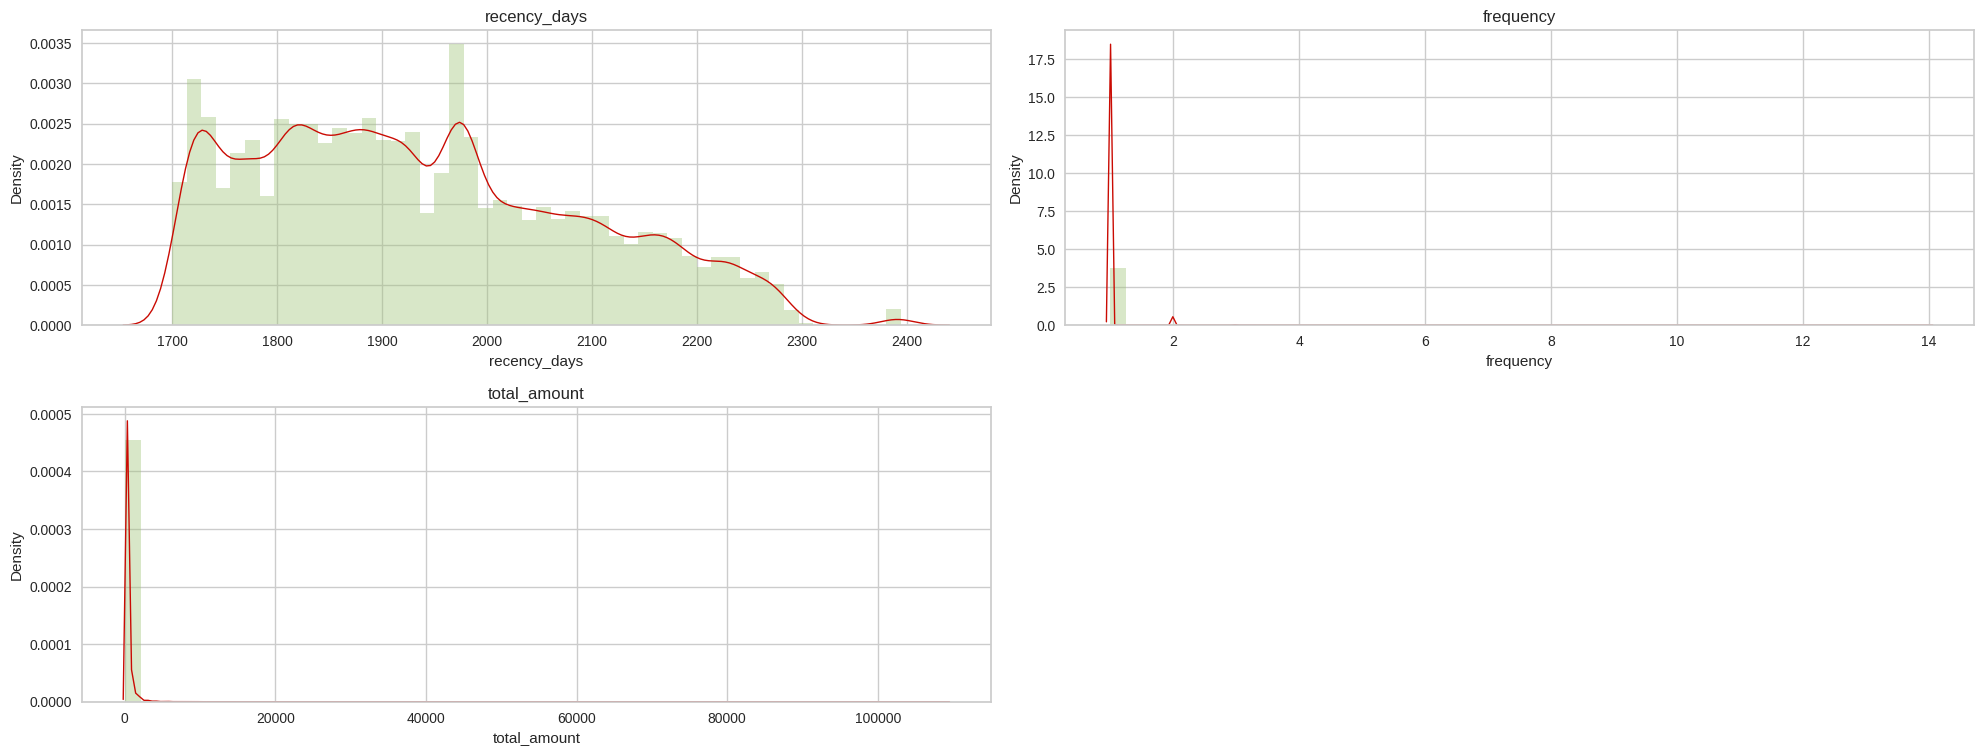

In [ ]:
# distplot combines the matplotlib.hist function with seaborn kdeplot()
# KDE Plot represents the Kernel Density Estimate
# KDE is used for visualizing the Probability Density of a continuous variable.
# KDE demonstrates the probability density at different values in a continuous variable.

# Mean of balance is $1500
# 'Balance_Frequency' for most customers is updated frequently ~1
# For 'PURCHASES_FREQUENCY', there are two distinct group of customers
# For 'ONEOFF_PURCHASES_FREQUENCY' and 'PURCHASES_INSTALLMENT_FREQUENCY' most users don't do one off puchases or installment purchases frequently
# Very small number of customers pay their balance in full 'PRC_FULL_PAYMENT'~0
# Credit limit average is around $4500
# Most customers are ~11 years tenure

plt.figure(figsize=(20,60))
for i in range(len(data.columns)):
  plt.subplot(16, 2, i+1)
  sns.distplot(data[data.columns[i]], kde_kws={"color": "r", "lw": 1, "label": "KDE"}, hist_kws={"color": "g"})
  plt.title(data.columns[i])

plt.tight_layout()

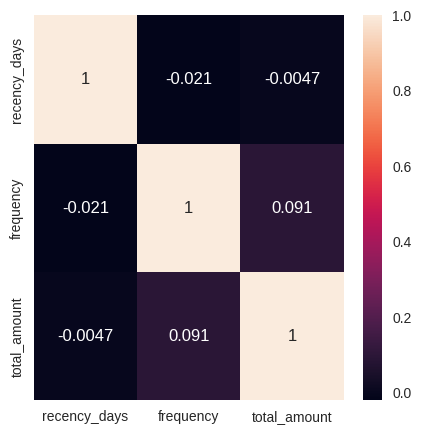

In [ ]:
correlations = data.corr()
f, ax = plt.subplots(figsize = (5, 5))
sns.heatmap(correlations, annot = True)
plt.show()

In [6]:
# Let's scale the data first
#data_scaled = preprocessing.minmax_scale(data)
#scaler = MinMaxScaler()
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data_scaled

array([[-0.82023697, -0.16458591, -0.112062  ],
       [-0.80058099, -0.16458591, -0.29171575],
       [ 1.96435913, -0.16458591, -0.19926556],
       ...,
       [ 0.16256165, -0.16458591, -0.20183406],
       [ 2.16747084, -0.16458591, -0.15816963],
       [-0.76782104, -0.16458591, -0.12492014]])

# Kmeans

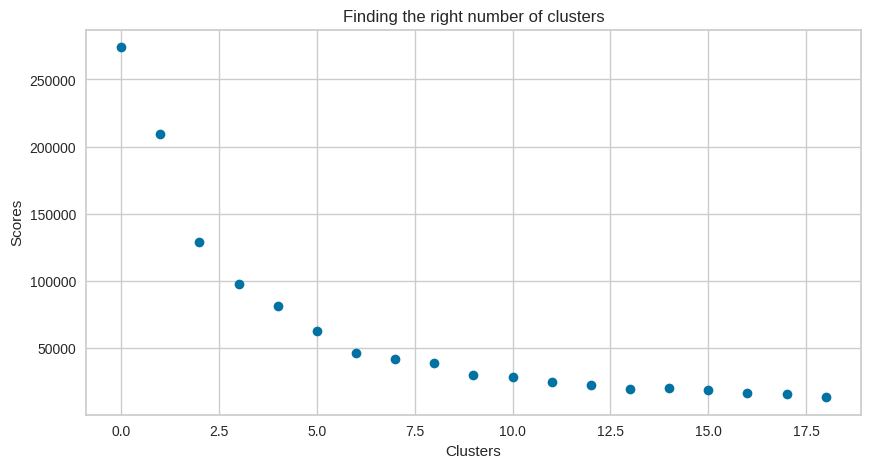

In [7]:
scores_1 = []

range_values = range(1, 20)

for i in range_values:
  kmeans = KMeans(n_clusters = i, n_init='auto')
  kmeans.fit(data_scaled)
  scores_1.append(kmeans.inertia_)
plt.figure(figsize = (10,5))
plt.plot(scores_1, 'bo')
plt.title('Finding the right number of clusters')
plt.xlabel('Clusters')
plt.ylabel('Scores')
plt.show()
# From this we can observe that, 5th cluster seems to be forming the elbow of the curve.
# Let's choose the number of clusters to be 3.

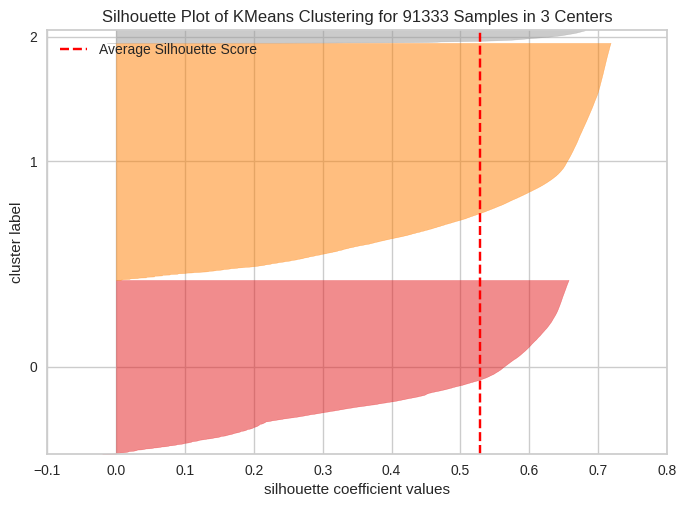

Silhouette Score(n=3): 0.528827190593406


In [8]:
# Instantiate the clustering model and visualizer
model = KMeans(3, n_init='auto')
visualizer = SilhouetteVisualizer(model)
visualizer.fit(data_scaled)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data
plt.show()
label = model.predict(data_scaled)
print(f'Silhouette Score(n=3): {silhouette_score(data_scaled, label)}')

In [9]:
kmeans = KMeans(3, n_init='auto')
kmeans.fit(data_scaled)
labels = kmeans.labels_

In [10]:
kmeans.cluster_centers_.shape

(3, 3)

In [11]:
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [data.columns])
cluster_centers

,recency_days,frequency,total_amount
0,0.989028,-0.164586,-0.021066
1,-0.713746,-0.164586,-0.023842
2,-0.115468,5.355842,0.737795


In [12]:
# In order to understand what these numbers mean, let's perform inverse transformation
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data = cluster_centers, columns = [data.columns])
#cluster_centers

In [13]:
y_kmeans = kmeans.fit_predict(data_scaled)
y_kmeans

array([2, 2, 0, ..., 0, 0, 2], dtype=int32)

In [14]:
# concatenate the clusters labels to our original dataframe
data_cluster = pd.concat([data, pd.DataFrame({'cluster':labels})], axis = 1)
data_cluster.head()

,recency_days,frequency,total_amount,cluster
0,1811.0,1.0,141.90,1
1,1814.0,1.0,27.19,1
2,2236.0,1.0,86.22,0
3,2020.0,1.0,43.62,0
4,1987.0,1.0,196.89,0


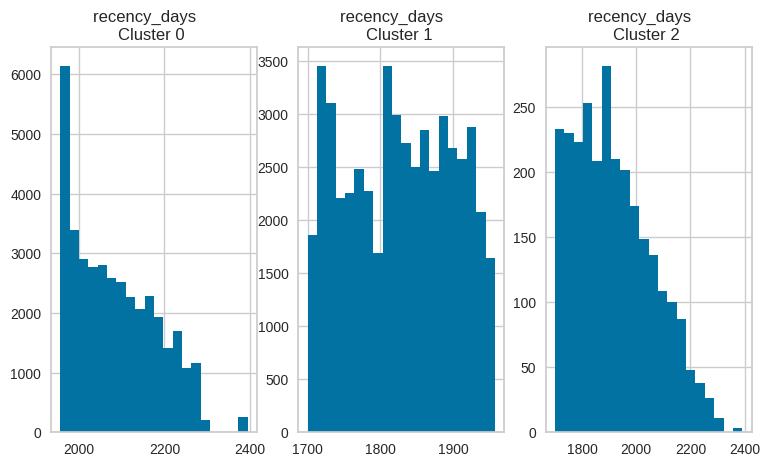

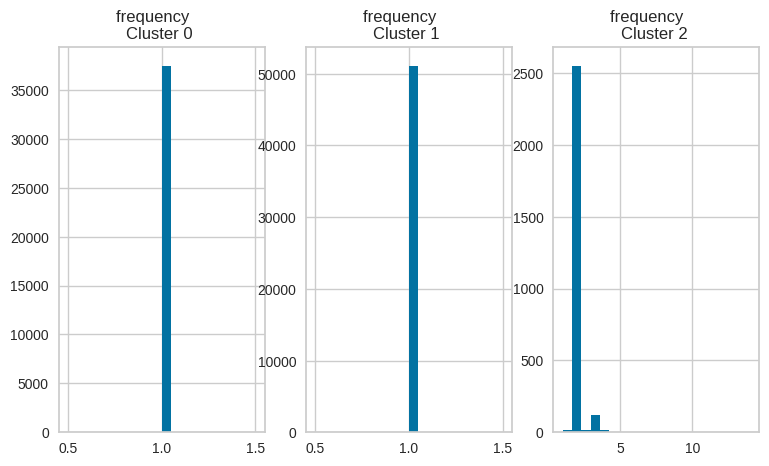

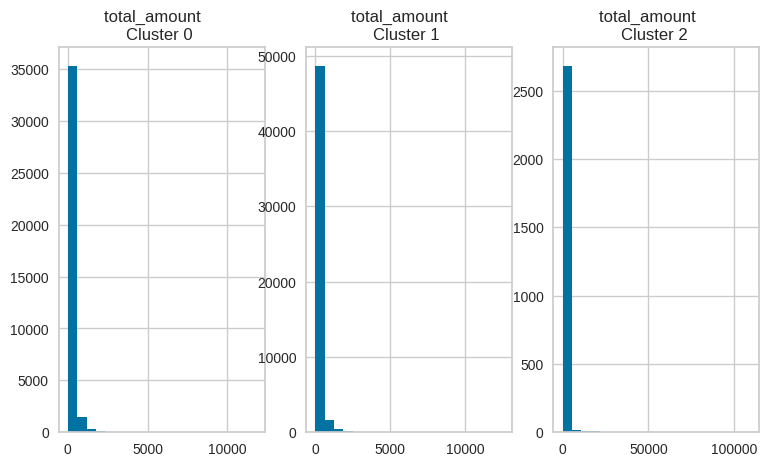

In [15]:
# Plot the histogram of various clusters
for i in data.columns:
  plt.figure(figsize = (25, 5))
  for j in range(3):
    plt.subplot(1,8,j+1)
    cluster = data_cluster[data_cluster['cluster'] == j]
    cluster[i].hist(bins = 20)
    plt.title('{}    \nCluster {} '.format(i,j))

  plt.show()

# PCA

In [16]:
# Obtain the principal components
pca = PCA(n_components=2)
principal_comp = pca.fit_transform(data_scaled)
principal_comp

array([[-0.03726302, -0.83132332],
       [-0.16424045, -0.85201924],
       [-0.62410525,  1.86159612],
       ...,
       [-0.2848588 ,  0.10603584],
       [-0.63435102,  2.06854516],
       [-0.05600502, -0.78312055]])

In [17]:
# Create a dataframe with the two components
pca_df = pd.DataFrame(data = principal_comp, columns =['pca1','pca2'])
pca_df.head()

,pca1,pca2
0,-0.037263,-0.831323
1,-0.164240,-0.852019
2,-0.624105,1.861596
3,-0.402033,0.468335
4,-0.196421,0.310970


In [18]:
# Concatenate the clusters labels to the dataframe
pca_df = pd.concat([pca_df,pd.DataFrame({'cluster':labels})], axis = 1)
pca_df

,pca1,pca2,cluster
0,-0.037263,-0.831323,1
1,-0.164240,-0.852019,1
2,-0.624105,1.861596,0
3,-0.402033,0.468335,0
4,-0.196421,0.310970,0
...,...,...,...
91328,-0.288450,0.057397,1
91329,3.837791,2.693409,0
91330,-0.284859,0.106036,0
91331,-0.634351,2.068545,0


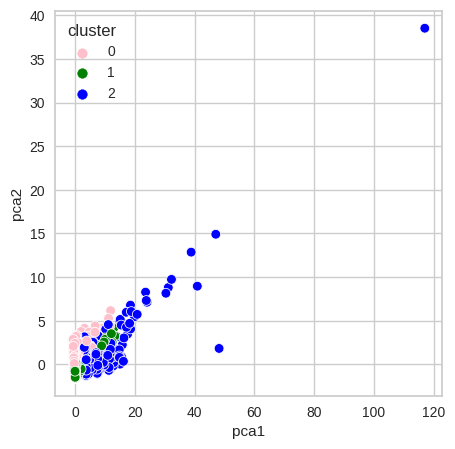

In [19]:
plt.figure(figsize=(5,5))
ax = sns.scatterplot(x="pca1", y="pca2", hue = "cluster", data = pca_df, palette =['pink','green','blue'])
plt.show()

In [20]:
import tensorflow as tf
#tf.config.run_functions_eagerly(True)
from keras import layers, losses
from keras.models import *
from keras.optimizers import *
from keras.utils import *
from keras.callbacks import *
from keras.preprocessing.image import *

from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.optimizers import SGD
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

In [21]:
encoding_dim = 3

input_df = Input(shape=(3,))


# Glorot normal initializer (Xavier normal initializer) draws samples from a truncated normal distribution

x = Dense(encoding_dim, activation='relu')(input_df)
x = Dense(64, activation='relu', kernel_initializer='normal')(x)
x = Dense(32, activation='relu', kernel_initializer='normal')(x)
encoded = Dense(10, activation='relu', kernel_initializer='normal')(x)
x = Dense(32, activation='relu', kernel_initializer='normal')(encoded)
x = Dense(64, activation='relu', kernel_initializer='normal')(x)
decoded = Dense(3, activation = 'sigmoid', kernel_initializer='normal')(x)
#decoded = Dense(3, activation = 'softmax', kernel_initializer = 'glorot_uniform')(x)


# autoencoder
autoencoder = Model(input_df, decoded)

#encoder - used for our dimention reduction
encoder = Model(input_df, encoded)
#optimizer=tf.keras.optimizers.Adam(clipvalue=0.5)
#autoencoder.compile(optimizer= optimizer, loss='categorical_crossentropy')
autoencoder.compile(optimizer= 'adam', loss='mean_squared_error')

In [22]:
autoencoder.fit(data_scaled, data_scaled, batch_size = 128, epochs = 25,  verbose = 1)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


714/714 [==============================] - 43s 56ms/step - loss: 0.8009
Epoch 2/25
714/714 [==============================] - 40s 56ms/step - loss: 0.7292
Epoch 3/25
714/714 [==============================] - 45s 63ms/step - loss: 0.7230
Epoch 4/25
714/714 [==============================] - 39s 55ms/step - loss: 0.6991
Epoch 5/25
714/714 [==============================] - 40s 56ms/step - loss: 0.6986
Epoch 6/25
714/714 [==============================] - 39s 55ms/step - loss: 0.6985
Epoch 7/25
714/714 [==============================] - 39s 55ms/step - loss: 0.6984
Epoch 8/25
714/714 [==============================] - 40s 56ms/step - loss: 0.6984
Epoch 9/25
714/714 [==============================] - 40s 55ms/step - loss: 0.6982
Epoch 10/25
714/714 [==============================] - 40s 56ms/step - loss: 0.6984
Epoch 11/25
714/714 [==============================] - 41s 57ms/step - loss: 0.6981
Epoch 12/25
714/714 [==============================] - 40s 56ms/step - loss: 0.6991
Epoch 13/25


In [23]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 3)                 12        
                                                                 
 dense_1 (Dense)             (None, 64)                256       
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 10)                330       
                                                                 
 dense_4 (Dense)             (None, 32)                352       
                                                                 
 dense_5 (Dense)             (None, 64)                2112  

In [24]:
autoencoder.save_weights('drive/MyDrive/clustering/autoencoder.h5')

In [25]:
pred = encoder.predict(data_scaled)

2855/2855 [==============================] - 12s 4ms/step


In [26]:
pred.shape

(91333, 10)

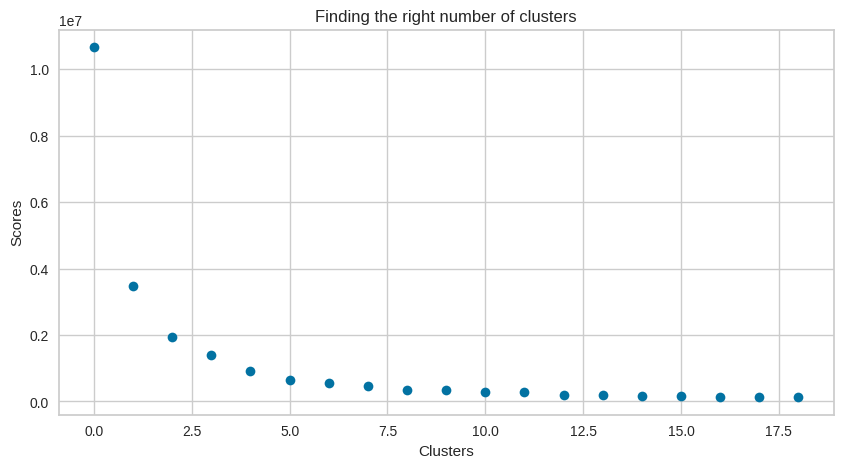

In [27]:
scores_2 = []

range_values = range(1, 20)

for i in range_values:
  kmeans = KMeans(n_clusters = i, n_init='auto')
  kmeans.fit(pred) #pred
  scores_2.append(kmeans.inertia_)
plt.figure(figsize = (10,5))
plt.plot(scores_2, 'bo')
plt.title('Finding the right number of clusters')
plt.xlabel('Clusters')
plt.ylabel('Scores')
plt.show()
# From this we can observe that, 5th cluster seems to be forming the elbow of the curve.
# Let's choose the number of clusters to be 3.

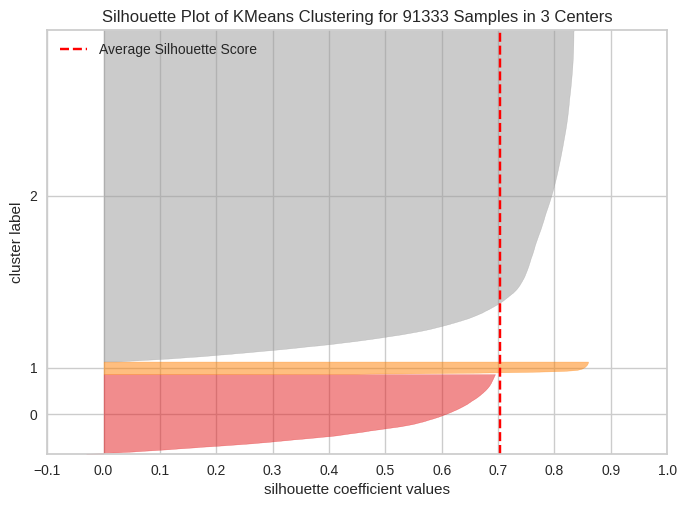

Silhouette Score(n=3): 0.7030580639839172


In [28]:
# Instantiate the clustering model and visualizer
model = KMeans(3, n_init='auto', random_state=42)
visualizer = SilhouetteVisualizer(model)
visualizer.fit(pred)    # Fit the pred to the visualizer
visualizer.poof()    # Draw/show/poof the data
plt.show()
label = model.predict(pred)
print(f'Silhouette Score(n=3): {silhouette_score(pred, label)}')

<ipython-input-29-bef1af2a4a8d>:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(scores_1, 'bo', color = 'r')
<ipython-input-29-bef1af2a4a8d>:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(scores_2, 'bo', color = 'g')


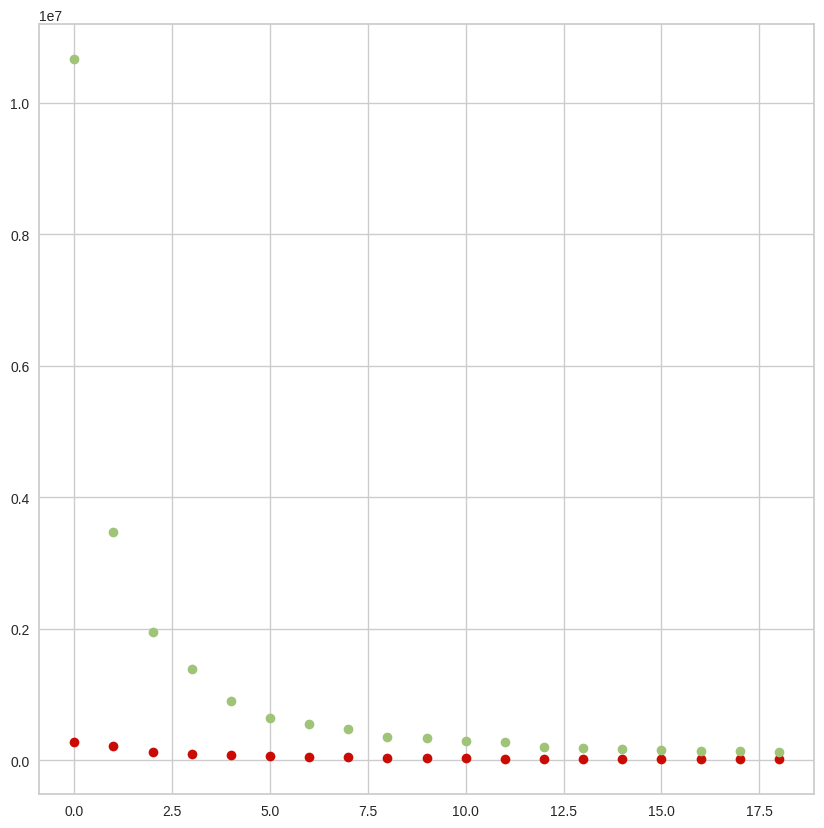

In [29]:
plt.figure(figsize=(10,10))
plt.plot(scores_1, 'bo', color = 'r')
plt.plot(scores_2, 'bo', color = 'g')
plt.show()

In [30]:
#kmeans = KMeans(3, n_init='auto', random_state=42)
kmeans = KMeans(3, n_init='auto')
kmeans.fit(pred)
labels = kmeans.labels_
y_kmeans = kmeans.fit_predict(pred)

In [31]:
df_cluster_dr = pd.concat([data, pd.DataFrame({'cluster':labels})], axis = 1)
df_cluster_dr.head()

,recency_days,frequency,total_amount,cluster
0,1811.0,1.0,141.90,2
1,1814.0,1.0,27.19,2
2,2236.0,1.0,86.22,0
3,2020.0,1.0,43.62,2
4,1987.0,1.0,196.89,2


In [32]:
pca = PCA(n_components=2)
prin_comp = pca.fit_transform(pred)
pca_df = pd.DataFrame(data = prin_comp, columns =['pca1','pca2'])
pca_df.head()

,pca1,pca2
0,-3.493554,-2.123190
1,-3.233847,-0.148459
2,6.060409,10.550985
3,-0.960823,2.384941
4,-2.339262,-1.682565


In [33]:
pca_df = pd.concat([pca_df,pd.DataFrame({'cluster':labels})], axis = 1)
pca_df.head()


,pca1,pca2,cluster
0,-3.493554,-2.123190,2
1,-3.233847,-0.148459,2
2,6.060409,10.550985,0
3,-0.960823,2.384941,2
4,-2.339262,-1.682565,2


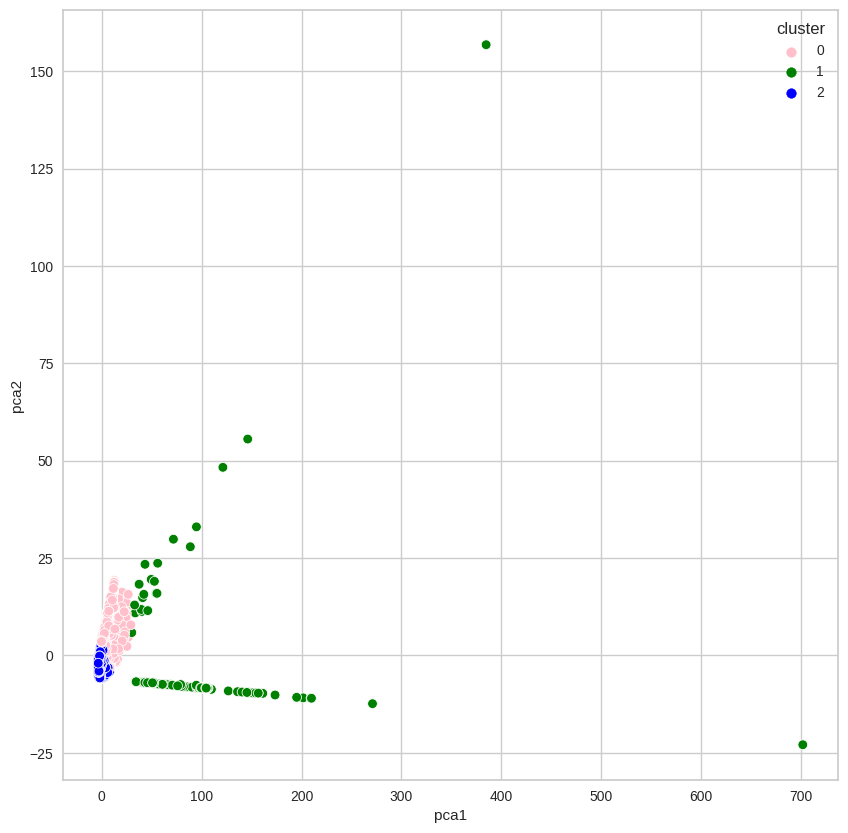

In [34]:
plt.figure(figsize=(10,10))
ax = sns.scatterplot(x="pca1", y="pca2", hue = "cluster", data = pca_df, palette =['pink','green','blue'])
plt.show()